# Exploratory data analysis

## Imports

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import re

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [5]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]


def combine_fyp(hashtag):
    if re.search(r"(^fy)|(^for)|(^4u)", hashtag, flags=re.IGNORECASE):
        return "fyp"
    else:
        return hashtag


def clean_hashtag_list(hashtag_list):
    return sorted(list(set([combine_fyp(hashtag) for hashtag in hashtag_list])))

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [150]:
tiktoks = pd.concat([pd.read_csv("./data/tiktoks_500.csv", usecols=range(1,8), parse_dates=["date"]), pd.read_csv("./data/tiktoks_100.csv", usecols=range(1,8), parse_dates=["date"]), pd.read_csv("./data/tiktoks.csv", usecols=range(1,8), parse_dates=["date"])]).drop_duplicates("video_id")
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.hashtags = tiktoks.hashtags.apply(clean_hashtag_list)
tiktoks["popularity"] = (tiktoks.n_likes/100) * (tiktoks.n_comments/100) *(tiktoks.n_shared/100) / 100000
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared,popularity
0,-4937456930930190897,"[aussie, biden2020, bidenharris2020, straya]",2020-11-07 01:51:07,-9074424973670462894,8300000,82700,238100,1634342.21
1,2837885220496618646,"[biden, biden2020, election2020, fyp, fürdich,...",2020-11-06 18:11:03,7802184149743201610,7200000,154800,536900,5984072.64
2,-7616690630605139661,"[biden2020, fyp]",2020-10-19 18:41:40,8599333060831776201,5000000,104800,400500,2098620.00
3,-1485617807006866345,"[biden2020, fyp, parati, repost, trump, trump2...",2020-06-16 22:41:10,-2163225678390988754,5000000,136100,356100,2423260.50
4,8847244246175840872,[biden2020],2020-10-31 23:04:55,8834409548135308984,4600000,68700,218100,689239.62


## Visualitions

We first create a list containing all the hashtags we used to collect the data.

Then we create the DataFrame `tiktoks_exploded` that contains one entry for each hashtags. This means that if a row had hashtags `['Biden2020', 'bidenharris2020']`, the exploded version will transform it in two distinct rows, each with a single hashtag

In [151]:
queried_hashtags = ["biden2020", "trump2020", "biden", "trump", "election2020", "2020election", "donaldtrump", "joebiden", "maga", "trumpout",
                    "democrat", "republican", "trumpvsbiden", "bidenvstrump", "voteblue", "votered"]
tiktoks_exploded = tiktoks.explode("hashtags")

Display the distribution of publications of each of the queried hashtags. Each bin represents a period of 10 days.

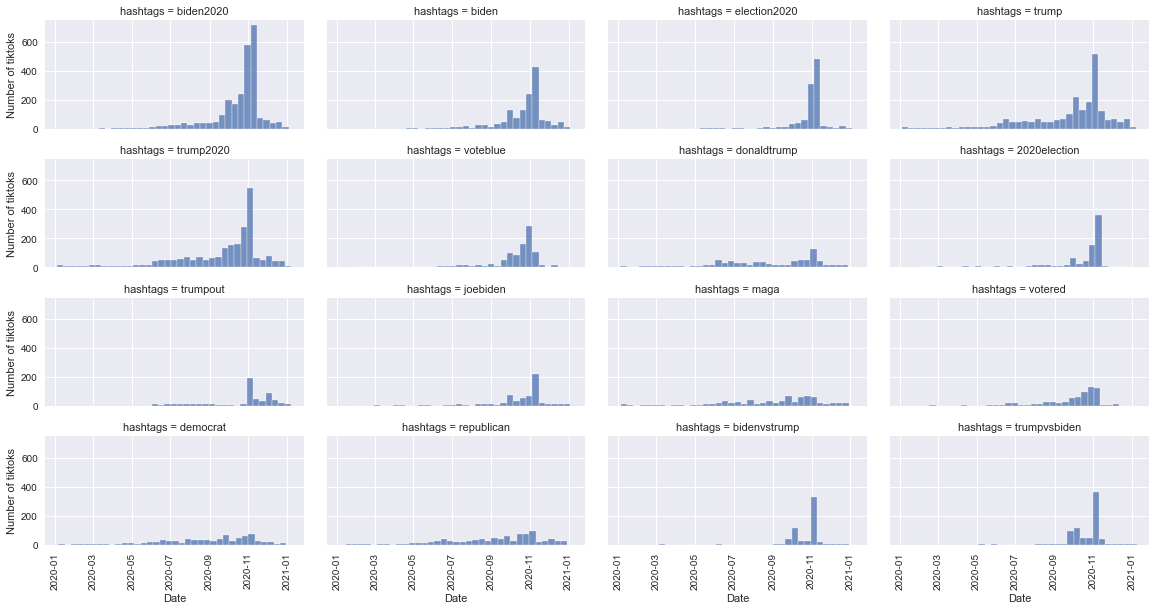

In [153]:
g = sns.FacetGrid(tiktoks_exploded.query("hashtags in @queried_hashtags"), col="hashtags", col_wrap = 4, sharex = True, sharey=True, height = 2, aspect=2)
g.map_dataframe(sns.histplot, x="date", binwidth=10)
g.set_axis_labels("Date", "Number of tiktoks")
g.set_xticklabels(rotation=90)

Display the top 20 most used hashtags in our dataset

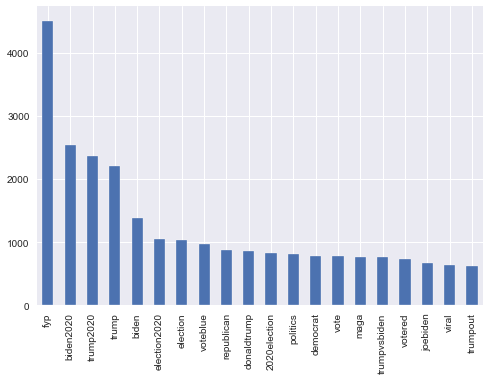

In [154]:
top_20 = tiktoks_exploded.hashtags.value_counts()[:20].plot(kind="bar")

# Looking at the distribution of hashtags overtime

Creating a new column to store only date of the video (to groupby videos based on date)

In [155]:
tiktoks_exploded['only_date'] = pd.to_datetime(tiktoks_exploded['date']).dt.date.astype(dtype='datetime64[ms]')

Grouping the tiktoks based on date and then hastags to the hashtag count perday

In [156]:
tiktoks_hash_grouped = tiktoks_exploded.groupby(["only_date","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktoks_hash_grouped

,only_date,hashtags,count
0,2020-01-03,2020,2
1,2020-01-03,america,2
2,2020-01-03,arianagrande,1
3,2020-01-03,donaldtrump,2
4,2020-01-03,fyp,3
...,...,...,...
18613,2020-12-31,viratkohli,1
18614,2020-12-31,whatilearned,1
18615,2020-12-31,whatwouldyoudo,1
18616,2020-12-31,wordsofwisdom,1


As there are many hashtags that have occured very less frequent of time compared to others, we remove all the hashtags that have occured less than specified number of times

In [179]:
minimum_occurances = 1000
hashtag_value_counts = tiktoks_exploded["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()

# hash_list contains the hashtags that have been used more than *minimum_occurances* number of times

In [180]:
tiktok_ht_min_occ = tiktoks_hash_grouped[tiktoks_hash_grouped['hashtags'].isin(hash_list)]

Creating a new dataframe with each hashtag as column and value as the count of hashtag occurance on that day

In [181]:
perday_hashtag_count = tiktok_ht_min_occ.pivot_table(values='count', index="only_date", columns='hashtags', aggfunc='first', fill_value=0)

In [182]:
GB=perday_hashtag_count.groupby([(perday_hashtag_count.index.year),(perday_hashtag_count.index.month)]).sum()
perday_hashtag_count_norm = GB.div(GB.sum(axis=1), axis=0)

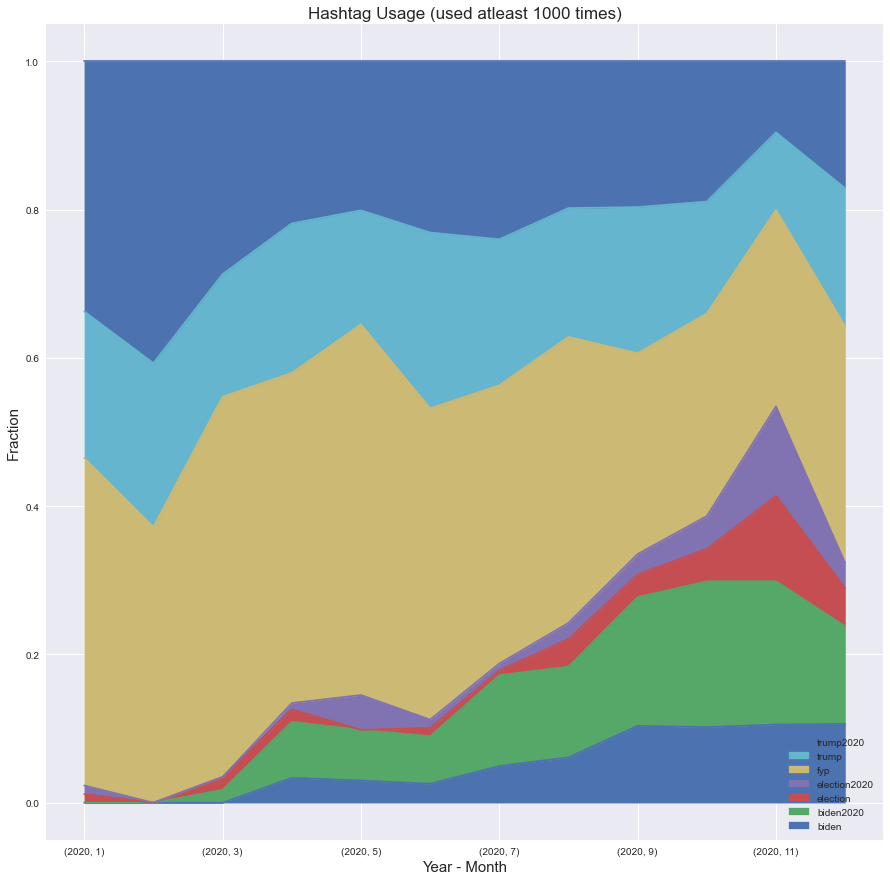

In [183]:
plt.style.use('seaborn')
perday_hashtag_count_norm.plot.area(figsize=(15, 15))
plt.xlabel('Year - Month', fontsize=15)
plt.ylabel('Fraction', fontsize=15)
plt.title('Hashtag Usage (used atleast {} times)'.format(minimum_occurances), fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)
plt.show()

Similar plot using Seaborn

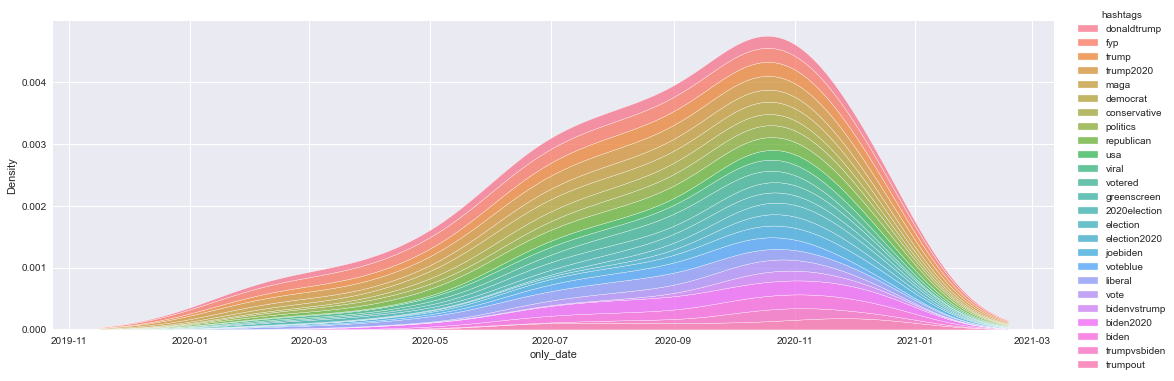

In [162]:
sns.displot(tiktok_ht_min_occ, x="only_date", hue="hashtags", kind="kde", multiple="stack", aspect = 3)

##### Using the area occupied by each hashtag in the plot we can how has the usage shifted over time

1. We should make small plots dividing over time to analyse easily

# Matching TikToks with events

Top 10 days when people posted tiktoks about the elections:

In [163]:
tiktoks["only_date"] = pd.to_datetime(tiktoks['date']).dt.date.astype(dtype='datetime64[ms]')
tiktoks.only_date.value_counts()[:10]

2020-11-04    604
2020-11-07    457
2020-11-05    419
2020-11-03    393
2020-11-06    315
2020-09-30    220
2020-11-08    199
2020-11-02    176
2020-10-27    104
2020-10-23    101
Name: only_date, dtype: int64

* Nov. 2-8 : Election Day was on the 3rd. With all the fuss about the count delays, recounts, fraud claims, etc... the hype lived up until the eighth
* Sep. 30 : The infamous first debate between Biden and Trump that ended up being a shitshow
* Oct. 27 : The Senate confirms Amy Coney Barrett to the supreme court one week before the election lol
* Oct. 23 : Second debate between Biden and Trump

# Cooccurances

Creates a co-occurance matrix using pandas

In [164]:
lst = list(tiktoks.hashtags)
u = (pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [174]:
def plot_co_occurance_matrix(matrix, threshold, figsize):
    fig, axes = plt.subplots(figsize=figsize)
    matrix = matrix.drop(index="fyp").drop(index="xyzbca")
    top_100_indices = matrix[matrix.sum(axis=1) > threshold].index
    top_100_indices = list(top_100_indices)
    print(top_100_indices)
    print(len(top_100_indices))
    mask = np.zeros_like(matrix[matrix.sum(axis=1) > threshold][top_100_indices], dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    #sns.heatmap(matrix[matrix.sum(axis=1) > threshold][top_100_indices], cmap="rocket_r", mask=mask, annot=True, fmt="d")
    sns.set_style("whitegrid")
    sns.heatmap(matrix[matrix.sum(axis=1) > threshold][top_100_indices], cmap="rocket_r", mask=mask)

We plot the co_occurance matrix only using the hashtags with more than 600 occurances

* We observe that (biden, trump) and (biden2020, trump2020) have the most co-occurances. Could it suggest that most TikToks are about the elections in general and not rooting for a particular party ?
* Biden appears a lot with `fyp`, whereas Trump barely does. Does it show that Biden supporters are the more experienced TikTok's user and know that platform better ? Which would also show Biden supporters are the younger generation.
* Without surprise, (Trump, Trump2020) and (Biden, Biden2020) appear often together.
* blm doesn't seem more corrolated to biden than trump

['2020election', 'america', 'biden', 'biden2020', 'bidenvstrump', 'blm', 'comedy', 'conservative', 'democrat', 'donaldtrump', 'dumptrump', 'election', 'election2020', 'funny', 'greenscreen', 'joebiden', 'liberal', 'maga', 'politics', 'president', 'republican', 'trump', 'trump2020', 'trumpout', 'trumpvsbiden', 'usa', 'viral', 'vote', 'voteblue', 'votered']
30


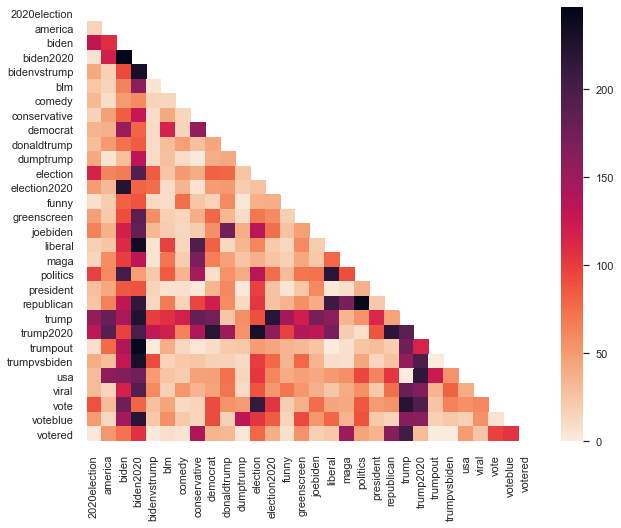

In [178]:
plot_co_occurance_matrix(v, 2000, (10,8))

Let us now try to get a 2D embedding of each word from this co-occurance matrix by using the Truncated SVD from SkLearn

# User Clustering using hashtags

Create a user profile based on hashtags i.e create a bag of hashtag vector.

First, we select the hashtags with minimum occurances

# Video Clustering using hashtags

## Word Cloud of Hashtags

In [ ]:
long_string = ','.join((list([a for b in tiktoks.hashtags.tolist() for a in b])))

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Word Cloud of Hashtags in USA map style.

In [ ]:
mask = np.array(Image.open("img/us.jpg"))
wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(long_string)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modelling of videos

In [ ]:
data_words = tiktoks.hashtags.values.tolist()

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

We shall remove those hashtags that have frequency less than the minimum frequency

In [ ]:
ids = [id2word.token2id[hash_list[i]] for i in range(len(hash_list))]
id2word.filter_tokens(bad_ids=ids)

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [ ]:
scores = pd.DataFrame(columns=["c_v", "u_mass"])


for n_topics in range(2, 20, 1):
    print("Number of topics : ", n_topics)
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_model_lda_u_mass = CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence() 
    print('Coherence Score c_v: ', coherence_lda)
    print('Coherence Score u_mass: ', coherence_lda_u_mass)
    scores.loc[n_topics] = {'c_v' : coherence_lda, 'u_mass': coherence_lda_u_mass}

In [ ]:
copy_score = scores.copy()
copy_score = (copy_score-copy_score.mean())/copy_score.std()

In [ ]:
ax = copy_score.reset_index().plot(x = 'index', y = ['c_v', 'u_mass'], sharey=False)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Score (C_v)")

In [ ]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared

Trying to reproduce https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf = tf.fit_transform([' '.join(hs) for hs in data_words])

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cs = linear_kernel(tfidf, tfidf)

In [ ]:
import numpy as np
from tqdm import tnrange
top_n_sentences = []

no_dups = np.array([' '.join(hs) for hs in data_words])
i = 0
top_frame = []
for c, z in zip(cs, tnrange(len(cs))):
    # Create vector of titles
    start_name = pd.Series([no_dups[i]]*15) 
    # Index of top 15 similar titles
    ix_top_n = np.argsort(-c)[0:15]
    cos_sim = pd.Series(c[ix_top_n])
    names = pd.Series(no_dups[ix_top_n])
    i +=1
    top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
top_frame = pd.concat(top_frame)
top_frame.columns = ['title1', 'title2', 'cos_sim']
# Remove the similarities for the same sentences
top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['title1'], top_frame['title2'])]
top_frame = top_frame[top_frame['is_same'] != True]
        
top_n_sentences.append(top_frame)

In [ ]:
top_n_sentences

In [ ]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] #TDS articles
edges = list(zip(top_frame['title1'], top_frame['title2']))
weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [ ]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

In [ ]:
# Takes some time for larger graphs

pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [ ]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [ ]:
frame_clust.groupby('Cluster').count()

In [ ]:
def find_n_top_words(topic):

    frame_clust['Title'] = frame_clust.apply(lambda row: " " + row['Title'] , axis=1)
    wordstring = frame_clust[frame_clust['Cluster']==topic]['Title'].str.cat()
    wordlist = wordstring.split(' ')
    wordfreq = [wordlist.count(w) for w in wordlist]


    pairs = [p for p in set(zip(wordlist, wordfreq)) if p[0]!='']
    top_n_words = sorted(pairs, key=lambda tup: tup[1], reverse=True)[:10]
    top_n_words = [w[0] for w in top_n_words]
    print("===== TOPIC ", topic)
    print(top_n_words)
    print("")
    return top_n_words

In [ ]:
for i in range(21):
    find_n_top_words(i)

## Hashtag Analysis

In [ ]:
tiktoks_hashtag_count = tiktoks.hashtags.apply(lambda x: len(x))
ax = sns.histplot(tiktoks_hashtag_count, discrete=True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

From the histogram above, we obtain an insight into the number of hashtags used per video. On average users use 5,6,7 hashtags per video and only few videos use more than 10 hashtags.

Next we build a graph of hashtags where each none of the craft represents a hashtag and an edge between two loads exist if the hashtags are mentioned together. We select hashtags that have appeared atleast 50 times. Additionally, we remove the `fyp` hashtag as it is used in almost all videos.

We define two functions to plot the network.

In [ ]:
def plotGraph(node_df, G, sizing=50, node_size='adjacency_frequency',layout=nx.kamada_kawai_layout):

        back_col = '#ffffff'
        edge_col = '#ece8e8'
        
        """
        normalise all graph metrics
        """
        #subset graph metrics
        X = node_df[node_df.columns[2:5]]

        #get columns labels
        cols = node_df.columns[2:5]

        #instantiate instance of MinMaxScaler class
        min_max_scaler = preprocessing.MinMaxScaler()

        #transform graph metrics
        X_scaled = min_max_scaler.fit_transform(X)

        #create new dataframe of scaled metrics
        plot_df = pd.DataFrame(X_scaled)

        plot_df.columns=cols

        for i in plot_df.columns:
            plot_df[i] = plot_df[i].apply(lambda x: x*sizing)


        #extract graph x,y co-ordinates from G instance
        pos = layout(G)

        #add position of each node from G to 'pos' key
        for node in G.nodes:
            G.nodes[node]['pos'] = list(pos[node])



        stack = []

        index = 0

        #add edges to Plotly go.Scatter object
        for edge in G.edges:

            x0, y0 = G.nodes[edge[0]]['pos']

            x1, y1 = G.nodes[edge[1]]['pos']

            weight = 0.5

            trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                               mode='lines',
                               line={'width': weight},
                               marker=dict(color=edge_col),
                               line_shape='spline',
                               opacity=1)

            #append edge traces
            stack.append(trace)

            index = index + 1

        #make a partly empty dictionary for the nodes
        marker = {'size':[],'line':dict(width=0.5,color=edge_col),'color':[]}


        #initialise a go.Scatter object for the nodes
        node_trace = go.Scatter(x=[], y=[], hovertext=[], text=[], mode='markers', textposition="bottom center",
                                hoverinfo="text", marker=marker)

        index = 0

        #add nodes to Plotly go.Scatter object
        for node in G.nodes():

            x, y = G.nodes[node]['pos']

            node_trace['x'] += tuple([x])

            node_trace['y'] += tuple([y])

            node_trace['text'] += tuple([node_df['hashtag'][index]])

            node_trace['marker']['color'] += tuple(list(node_df.community))

            node_trace['marker']['size'] += tuple([list(node_df.adjacency_frequency)[index]])

            index = index + 1

        #append node traces
        stack.append(node_trace)


        #set up axis for plot
        axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
                  zeroline=False,
                  showgrid=False,
                  showticklabels=False,
                  title=''
                  )

        #set up figure for plot
        figure = {
        "data": stack,
        "layout":
        go.Layout(title=str('Hashtag Network'),
                    font= dict(family='Arial',size=20),
                    width=1100,
                    height=1100,
                    autosize=False,
                    showlegend=False,
                    xaxis=axis,
                    yaxis=axis,
                    margin=dict(
                    l=40,
                    r=40,
                    b=85,
                    t=100,
                    pad=0,

            ),
            hovermode='closest',
            plot_bgcolor=back_col, #set background color
            )}

        #plot the figure
        iplot(figure)

        return

In [ ]:
def plotCommunity(node_df,colorscale=False):

        #make copy of node dataframe
        df_temp = node_df.copy()

        #change community label to string (needed for plot)
        df_temp['community'] = df_temp['community'].map(lambda x: str(x))

        #conditionals for plot type
        if colorscale == False:

            fig = px.sunburst(df_temp, path=['community', 'hashtag'], values='adjacency_frequency',color='community',hover_name=None,
                          hover_data=None)
        else:
            fig = px.sunburst(df_temp, path=['community', 'hashtag'], values='adjacency_frequency',
                          color='betweeness_centrality', hover_data=None,
                          color_continuous_scale='blugrn',
                          color_continuous_midpoint=np.average(df_temp['betweeness_centrality'], weights=df_temp['betweeness_centrality']))

        #add margin to plot
        fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

        #offline sunburst plot
        iplot(fig)

        return

In [ ]:
minimum_occurances = 50
hashtag_value_counts = tiktoks_exploded["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()
hash_list.remove("fyp")

In [ ]:
hashtag_graph = nx.Graph()

for hashtag_list in data_words:
    if len(hashtag_list) == 1:
        if (hashtag_list[0] in hash_list):
            hashtag_graph.add_node(hashtag_list[0])
    else:
        links = list(combinations(hashtag_list, 2))
        
        for ht1, ht2 in links:
            if (ht1 in hash_list) and (ht2 in hash_list):
                if not hashtag_graph.has_edge(ht1, ht2):
                    hashtag_graph.add_edge(ht1, ht2)

In [ ]:
nodes_df = pd.DataFrame(hashtag_graph.nodes()).rename(columns={0:"hashtag"})

Source for below analysis: https://towardsdatascience.com/using-network-science-to-explore-hashtag-culture-on-instagram-1f7917078e0

First we calculate the adjacency value i.e. number of hashtags each hashtag is connected to. Then we compute the betweenness centrality each hashtag which is the number of these shortest paths that pass through the node in the graph. Next, we compute clustering coefficient which is measure of the degree to which nodes in a graph tend to cluster together. In this case, it is the fraction of possible triangles through that node that exist. 

Next, we identify the communities of hashtags in the network using `Clauset-Newman-Moore greedy modularity maximization` method. The algorithm begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists and then assign each hashtag a community.

In [ ]:
# adjacency_frequency
hashtag_adjacencies = dict(hashtag_graph.adjacency())
nodes_df['adjacency_frequency'] = nodes_df['hashtag'].map(lambda x: len(hashtag_adjacencies[x]))

# betweeness_centrality
hashtag_betweeness = nx.betweenness_centrality(hashtag_graph)
nodes_df['betweeness_centrality'] = nodes_df['hashtag'].map(lambda x: hashtag_betweeness[x])

# clustering_coefficient
hashtag_clustering_coeff = nx.clustering(hashtag_graph)
nodes_df['clustering_coefficient'] = nodes_df['hashtag'].map(lambda x: hashtag_clustering_coeff[x])

# community
communities = greedy_modularity_communities(hashtag_graph)
communities_dict = {}

nodes_in_community = [list(i) for i in communities]

for i in nodes_in_community:
    communities_dict[nodes_in_community.index(i)] = i

def community_allocation(source_val):
    for k,v in communities_dict.items():
        if source_val in v:
            return k

nodes_df['community'] = nodes_df['hashtag'].map(lambda x: community_allocation(x))

Now, we plot the network and communities for analysis.

In [ ]:
plotCommunity(nodes_df)

![communities](./img/plots/communities.png)

When we consider, hashtags that have appeared at least 50 times we find that there are two main communities. We can interpret these as seasonal and those used consistently. The first community that is in blue has the hashtags that were populat during the 2020 elections like trump/biden2020, uselections, 2020elections, bidenharris, kamalaharris, trumpout. Not only these but due to the pandemic during that season we see homeoffice. In the second community that is in red, we see those that have themes or persona attached to them and those that are used generally in making tiktoks. 

##### I cannot distinguish between these two. 😂 May be we can discuss together.

In [ ]:
plotGraph(nodes_df, hashtag_graph)

![hashtag](./img/plots/hashtag_network.png)

In the above plot that gives the view about the network of the hashtags, the color identifies the community and size denotes the adjacency values of each node. We observe that almost all nodes have the same adjacency values indicating that people used the common hastags together. This is possibliy indicating that the users have used common hashtags to increase their reach.